# Face Detection, Allignment, Embeddings, Clustering

### Notebook content:
- 1 Correct jpg files metadata
- 2 MTCNN (detect faces on photos)
- 3 Filter results (remove bad quality photos)
- 4 FaceNet embeddings (obtain 128-dim vector/embedding representing faces features numerically with FaceNet)
- 5 t-SNE: 2-D representation of clustering similar photos together and separating different photos further from each other. 

In [1]:
# Load libraries and helper functions by running utils.py with a jupyter magic function:
%run utils.py

Using TensorFlow backend.
C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\evgen\Anaconda3\envs\DL_env\lib\sit

Libraries and functions loaded


## 1. Correct jpg files metadata (creation-time)
It is often that metadata for jpg files is wrong (e.g. the camera was not set correctly), here are some usefull functions to check and correct the metadata:

### Check metadata for jpg files

In [2]:
# Scan over immediate subfolders in the main directory folder and check creation times within these subfolders
directory = r'Test\Photoset'
print_creation_times_for_subfolders(directory)

Number of immediate subfolders:  3

0
Test\Photoset\2008
4 jpg files in subdirectory
years: 2008 - 2008 ; months: 6 - 12 ; days: 1 - 28

1
Test\Photoset\2018
7 jpg files in subdirectory
years: 2018 - 2018 ; months: 9 - 9 ; days: 8 - 8

2
Test\Photoset\2020
3 jpg files in subdirectory
years: 2020 - 2020 ; months: 6 - 6 ; days: 13 - 13



In [3]:
# Check creation times in one of the subfolders:
subdirectory = r'Test\Photoset\2020'
get_creation_times_range(subdirectory)

years: 2020 - 2020 ; months: 6 - 6 ; days: 13 - 13


In [4]:
file_path = r'Test\Photoset\2018\0.jpeg'
get_creation_time(file_path)

'2018:09:08 00:00:00'

### Correct metadata (if needed)

In [5]:
# Change single file creation datetime (if needed)
file_path_to_change_metadata = r'Test\Photoset\2018\0.jpeg'
change_jpg_datetime(file_path_to_change_metadata, 2018, 9, 8)

In [6]:
# Change creation times of all jpg files in a folder to specific date
folder_to_change_metadata = r'Test\Photoset\2020'
change_datetime_in_folder(folder_to_change_metadata, 2020, 6, 13)

# 2. MTCNN (Multi-Task CNN)
Multi Task CNN performs multiple tasks simultaneously: face detection and face allignment - i.e. finding face box and landmarks (coordinates of eyes, nose, mouth edges) on the face.
- Original paper (2016): https://arxiv.org/abs/1604.02878  
- Github repo: https://github.com/ipazc/mtcnn by https://www.linkedin.com/in/ivandepazcenteno/:   
- Description with examples https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/  

In [4]:
# Scan a folder with subfolders containing photos and perfrom MTCNN on all photos, save results to a csv file
# Depending on the archive size, scanning photos might take a lot of time.
# The results are saved to the MTCNN_results file for each photo scanned.
# Thus, if interrupted, the results are still saved, and the scan can continued later.
# If new photos are added to the archive this function will do MTCNN only for new photos.
# If one wants a completly new scan with different parameters (min_face_size) new MTCNN_results csv file should be created

# Main archive photo folder with subfolders containing photos
photo_folder = r'Test\Photoset'
# csv file to save scan results
MTCNN_results_file_path = r'Test\MTCNN_results.csv'

In [5]:
%%time
# Run MTCNN and save results:
get_mtcnn_results(photo_folder, MTCNN_results_file_path, min_face_size = 100)


14 jpg files in directory
14 jpg files already scanned before


100%|██████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<?, ?it/s]


Wall time: 1.7 s


## 3. Filter photos

In [6]:
df = load_MTCNN_scan_results(MTCNN_results_file_path)
df.tail()

14 jpg files scanned with MTCNN
14 jpg files with detected faces
28 total faces detected on all photos


,file_path,creation_date,MTCNN_result
23,Test\Photoset\2020\IMG_3798.JPG,2020-06-13,"{'box': [2868, 2381, 148, 165], 'confidence': ..."
24,Test\Photoset\2020\IMG_3798.JPG,2020-06-13,"{'box': [3530, 1464, 164, 226], 'confidence': ..."
25,Test\Photoset\2020\IMG_3798.JPG,2020-06-13,"{'box': [3375, 2210, 150, 192], 'confidence': ..."
26,Test\Photoset\2020\IMG_3836.JPG,2020-06-13,"{'box': [2503, 3312, 124, 138], 'confidence': ..."
27,Test\Photoset\2020\IMG_3836.JPG,2020-06-13,"{'box': [1601, 3273, 170, 209], 'confidence': ..."


## MTCNN results need filtering for several reasons:
E.g: Not a face detected, face size is too small for further processing, photo not in front (person looks to the side), face not in focus, face is inclined too much, grayscale image, etc...

### Define the filters:
- **confidence_filter** allows to filter out photos with low confidence. MTCNN provides its confidence in a found face as one of it output results. Low confidence values correspond to either not-a-face (objects resembling face) or occluded faces - it is better to filter them out, e.g. faces with confidence less than 0.99 will be excluded.

- **face_height_filter**. Faces with height less than face_height_filter will be excluded.  Although MTCNN takes min_face_size as an argument some of the found faces are smaller than the min_face_size parameter.

- **nose_shift_filter**. If nose shift is bigger than e.g 15 - face will be excluded. I tried to filter out the photos which are not in front. Nose shift is determined from positions of eyes and nose landmarks and if the nose is strongly shifted relative to center between the eyes the photo is filtered out. 

- **eye_line_angle_filter**. If eye_line_angle is more than eye_line_angle_filter - face will be excluded. All photos will be rotated so that the eyeline is horizontal.

- **sharpness_filter**. Assessment of bluriness of an image. Bigger value - lower bluriness. Idea taken from https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/ and modified. I found it emperically that (max-min)**2/var is working better than simple variance as an assessment of bluriness, it is also implemented on a central part of the face around nose (not on the whole face image). If sharpness is less than sharpness_filter face will be excluded

C:\Users\evgen\OneDrive - Imperial College London\ML\_Face\utils.py:422: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['face_file_path'] = np.NaN
0it [00:00, ?it/s]

0 image from total of 1 scanned images
Test\Photoset\2008\1.jpg
angle = -15 ; nose shift = 1 ; sharpness = 528


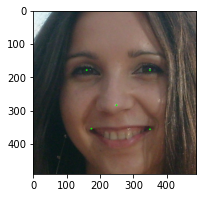

1it [00:00,  2.79it/s]

1 image from total of 2 scanned images
Test\Photoset\2008\1.jpg
angle = -21 ; nose shift = 7 ; sharpness = 191


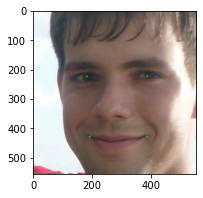

2it [00:00,  3.00it/s]

2 image from total of 4 scanned images
Test\Photoset\2008\S7300012.JPG
angle = -11 ; nose shift = 17 ; sharpness = 243


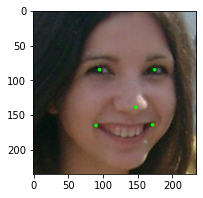

4it [00:00,  3.55it/s]

3 image from total of 5 scanned images
Test\Photoset\2008\S7300073.JPG
angle = -8 ; nose shift = 5 ; sharpness = 94


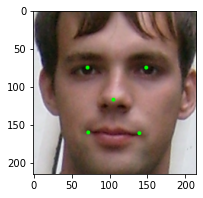

5it [00:01,  3.36it/s]

4 image from total of 6 scanned images
Test\Photoset\2008\S7300639.JPG
angle = 1 ; nose shift = 12 ; sharpness = 120


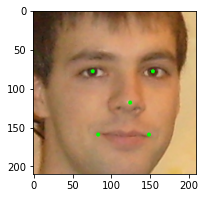

6it [00:01,  3.24it/s]

5 image from total of 7 scanned images
Test\Photoset\2008\S7300639.JPG
angle = -5 ; nose shift = 5 ; sharpness = 118


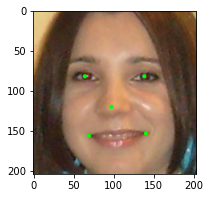

7it [00:01,  3.16it/s]

6 image from total of 8 scanned images
Test\Photoset\2018\0.jpeg
angle = 17 ; nose shift = 25 ; sharpness = 47


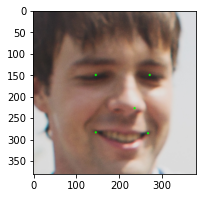

8it [00:02,  2.16it/s]

7 image from total of 9 scanned images
Test\Photoset\2018\0.jpeg
angle = 6 ; nose shift = 25 ; sharpness = 53


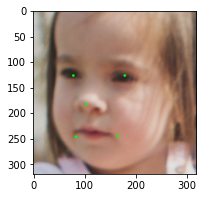

9it [00:03,  1.90it/s]

8 image from total of 13 scanned images
Test\Photoset\2018\x-254.jpg
angle = 11 ; nose shift = 10 ; sharpness = 47


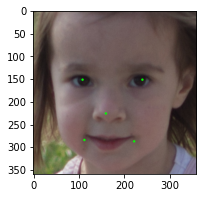

13it [00:04,  2.38it/s]

9 image from total of 14 scanned images
Test\Photoset\2018\x-347.jpg
angle = -1 ; nose shift = 6 ; sharpness = 52


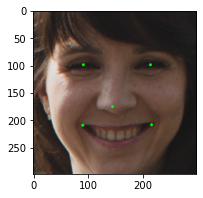

14it [00:04,  2.02it/s]

10 image from total of 15 scanned images
Test\Photoset\2018\x-347.jpg
angle = -9 ; nose shift = 24 ; sharpness = 57


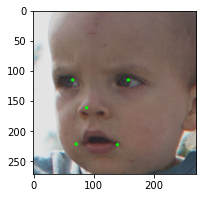

15it [00:05,  1.81it/s]

11 image from total of 16 scanned images
Test\Photoset\2018\x-347.jpg
angle = -7 ; nose shift = 0 ; sharpness = 58


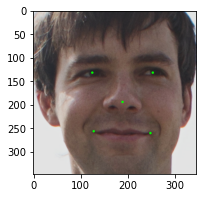

16it [00:06,  1.73it/s]

12 image from total of 17 scanned images
Test\Photoset\2018\x-363.jpg
angle = -8 ; nose shift = 1 ; sharpness = 82


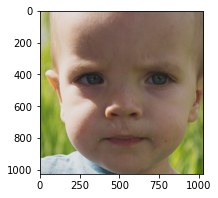

17it [00:06,  1.56it/s]

13 image from total of 18 scanned images
Test\Photoset\2018\x-38.jpg
angle = 0 ; nose shift = 14 ; sharpness = 39


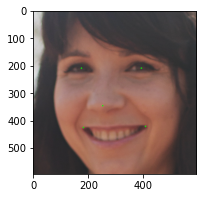

18it [00:07,  1.55it/s]

14 image from total of 19 scanned images
Test\Photoset\2018\x-74.jpg
angle = 1 ; nose shift = 3 ; sharpness = 39


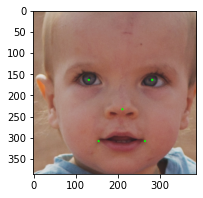

19it [00:07,  1.74it/s]

15 image from total of 21 scanned images
Test\Photoset\2020\IMG_3682.JPG
angle = -8 ; nose shift = 21 ; sharpness = 263


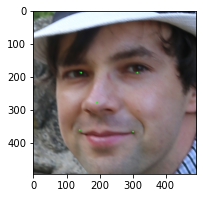

21it [00:08,  1.94it/s]

16 image from total of 22 scanned images
Test\Photoset\2020\IMG_3682.JPG
angle = 13 ; nose shift = 3 ; sharpness = 252


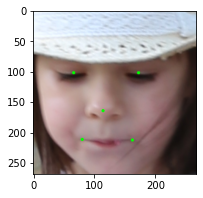

22it [00:09,  1.82it/s]

17 image from total of 24 scanned images
Test\Photoset\2020\IMG_3798.JPG
angle = -10 ; nose shift = 11 ; sharpness = 155


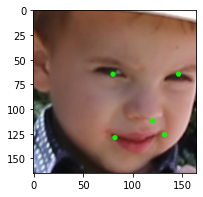

24it [00:09,  2.10it/s]

18 image from total of 25 scanned images
Test\Photoset\2020\IMG_3798.JPG
angle = 5 ; nose shift = 2 ; sharpness = 136


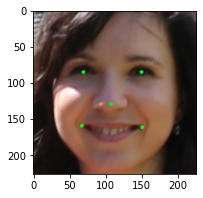

25it [00:10,  1.93it/s]

19 image from total of 26 scanned images
Test\Photoset\2020\IMG_3798.JPG
angle = -4 ; nose shift = 7 ; sharpness = 149


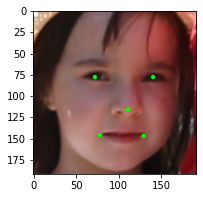

26it [00:11,  1.84it/s]

20 image from total of 27 scanned images
Test\Photoset\2020\IMG_3836.JPG
angle = -11 ; nose shift = 8 ; sharpness = 106


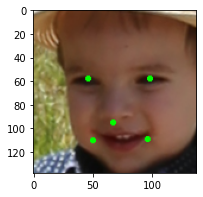

27it [00:11,  1.71it/s]

21 image from total of 28 scanned images
Test\Photoset\2020\IMG_3836.JPG
angle = -4 ; nose shift = 5 ; sharpness = 83


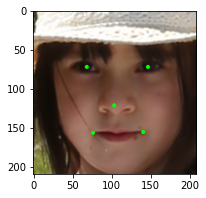

28it [00:12,  2.23it/s]


,file_path,creation_date,MTCNN_result,face_file_path


In [7]:
# Let's define the filters:
confidence_filter = 0.98
face_height_filter = 10
nose_shift_filter = 25
eye_line_angle_filter = 45
sharpness_filter = 20
# grayscale_image_filter is on by default, so no grayscale images will pass through

# And preview the images (one can find appropriate filters depending on the task)
# The landmarks on faces are shown in preview mode and are not saved in the save mode
save_image_folder = False
preview = True

plt.rcParams["figure.figsize"] = (3,3)
image_filter(df[0:100], save_image_folder, preview, confidence_filter, face_height_filter, nose_shift_filter, eye_line_angle_filter, sharpness_filter)

In [8]:
%%time
# Now that we decided on filter parameters for the task, let's get and save the filtered results:
save_image_folder = r'Test\Cropped_face_images'
preview = False

df_filtered = image_filter(df, save_image_folder, preview, confidence_filter, face_height_filter, nose_shift_filter, eye_line_angle_filter, sharpness_filter)

#file_path_filtered_results = r'output\MTCNN_min_face_200_filtered.csv'
file_path_filtered_results = r'Test\MTCNN_results_filtered.csv'

print('Number of faces before filtering:', len(df), 'Number of faces after filtering:', len(df_filtered))
df_filtered.to_csv(file_path_filtered_results,index=False)

0it [00:00, ?it/s]C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
28it [00:09,  3.05it/s]

Number of faces before filtering: 28 Number of faces after filtering: 22
Wall time: 9.23 s


In [9]:
#df_filtered = pd.read_csv(r'output\MTCNN_min_face_200_filtered.csv')
df_filtered = pd.read_csv(file_path_filtered_results)
print(len(df_filtered))
df_filtered.head()

22


,file_path,creation_date,MTCNN_result,face_file_path
0,Test\Photoset\2008\1.jpg,2008-06-01,"{'box': [434, 568, 400, 490], 'confidence': 0....",Test\Cropped_face_images\0.jpg
1,Test\Photoset\2008\1.jpg,2008-06-01,"{'box': [1228, 247, 473, 555], 'confidence': 0...",Test\Cropped_face_images\1.jpg
2,Test\Photoset\2008\1.jpg,2008-06-01,"{'box': [219, 1059, 850, 1066], 'confidence': ...",Test\Cropped_face_images\2.jpg
3,Test\Photoset\2008\S7300012.JPG,2008-08-02,"{'box': [1025, 919, 167, 235], 'confidence': 0...",Test\Cropped_face_images\3.jpg
4,Test\Photoset\2008\S7300073.JPG,2008-08-02,"{'box': [1142, 932, 167, 215], 'confidence': 0...",Test\Cropped_face_images\4.jpg


## 4. FaceNet Embeddings

In [10]:
# load the pretrained facenet model
# The model is taking 160X160 colored figure as input 
# And outputs 128 value vector of embedding generated from this figure
model = load_model(r'facenet_keras_pretrained/model/facenet_keras.h5')
print('model_input:', model.inputs)
print('model_output:', model.outputs)
model.summary()

model_input: [<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
model_output: [<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]
Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1

C:\Users\evgen\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
%%time
# Get embeddings for all face images
embeddings = []
for file_path in tqdm(df_filtered['face_file_path']):
    emb = get_facenet_embedding(file_path, model)
    embeddings.append(emb)
embeddings = np.array(embeddings)
#print(embeddings.shape)

# Save embeddings to the file
embeddings_file_path = r'Test\embeddings'
np.save(embeddings_file_path, embeddings)

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  7.90it/s]

Wall time: 2.81 s


## 5. t-SNE

In [12]:
# Load filetered results
df_filtered = pd.read_csv(file_path_filtered_results)

# load the embeddings
X = np.load('Test\embeddings.npy')

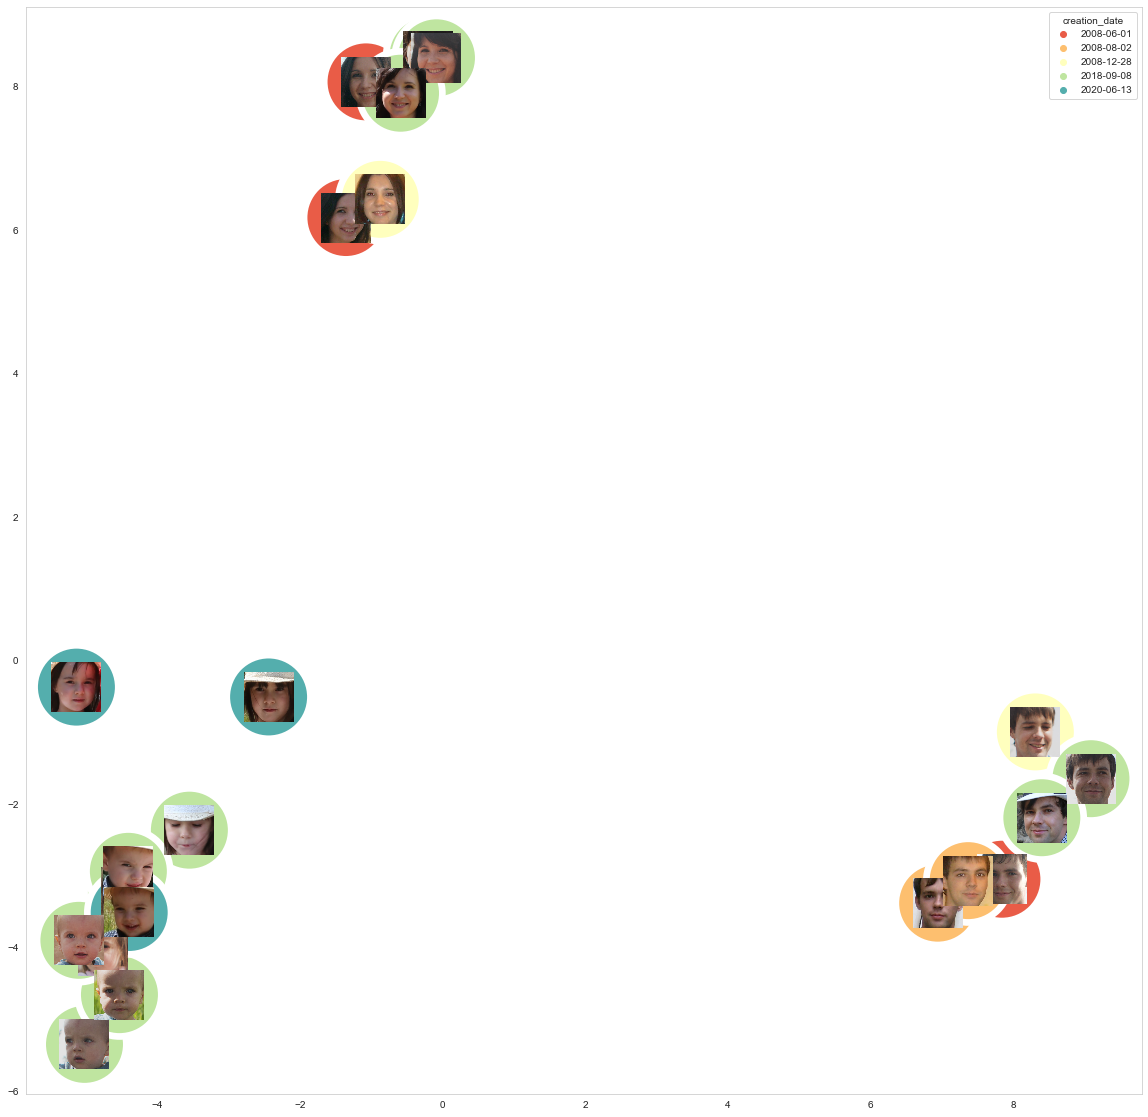

In [24]:
# Calculate t-SNE
model = PCA(n_components=2)
#model = TSNE(perplexity=2, learning_rate = 1000, n_iter=1000, random_state=0)

X_ = model.fit_transform(X)

x = X_[:,0]
y = X_[:,1]
paths =  df_filtered.face_file_path
creation_dates = df_filtered.creation_date


# The idea on how to plot faces is taken from https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
def getImage(path, size):
    image = plt.imread(path)
    image = resize_image(image, size)
    return OffsetImage(image)

plt.rcParams["figure.figsize"] = (20,20)
# This part is plotting faces
fig, ax = plt.subplots()
ax.scatter(x, y)
for x0, y0, path in zip(x, y, paths):
    ab = AnnotationBbox(getImage(path, (50,50)), (x0, y0), frameon=False)
    ax.add_artist(ab)

# This part is plotting colors
# Creation date is shown with colors on the plot below
# Spectral(rainbow) palette is used with older photos shown in red and recent in blue
sns.scatterplot(x=x, y=y, hue = creation_dates, s=7000, palette=sns.color_palette('Spectral',len(set(creation_dates))))
#plt.legend([],[], frameon=False) # hide the legend if it too long

# Set figure background
sns.set_style("whitegrid", {'axes.grid' : False,'axes.facecolor': 'white'})
plt.show()

As we see t-SNE separated these photos to groups using face embeddings generated by FaceNet. t-SNE is not ideal (one photo of my daughter mixed with my son's phots on this figure for example), and the result depends on the hyperparameters of the t-SNE algorithm. It also initialize randomly, so changing random_state brings different results. The output becomes more robust and accurate if more photos is used as is shown below for 1700 facial images from my archive. On this figure I can clearly members of our family and friends nicely separated to groups.<img src="Test/all.png">
# Do try it for your photo archive!